In [117]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import os
from sklearn.preprocessing import LabelEncoder

Upload the labels.csv and processed_counts.csv files to colab or your local workspace.

This data associates a cell barcode, such as "AAAGCCTGGCTAAC-1", to a certain cell type label, such as "CD14+ Monocyte". For each cell barcode, there are also log RNA seq counts of 765 different genes, such as HES4.

label.csv stores the association between a cell barcode and a cell type label.

processed_counts.csv stores the normalized log read counts for each cell, where each row represents a single cell, and each column represents a gene.

In [118]:
labels_pd = pd.read_csv("labels.csv")
counts_pd = pd.read_csv("processed_counts.csv")

In [119]:
import random
def shuffle_data(x, y):
    X = pd.DataFrame({i: [] for i in x.columns})
    Y = pd.DataFrame({i: [] for i in y.columns})
    ids = list(range(len(x)))
    while len(ids) > 0:
        random_id = random.choice(ids)
        X.loc[len(X)] = x.iloc[random_id,]
        Y.loc[len(Y)] = y.iloc[random_id,]
        ids.remove(random_id)
    return X, Y

In [120]:
x, y = shuffle_data(counts_pd, labels_pd)

Shuffle your data. Make sure your labels and the counts are shuffled together.

Split into train and test sets (80:20 split)

In [121]:
def train_test_split(x, y, test_percent=0.2):
    X_train, X_test, y_train, y_test = [], [], [], []
    threshold_number = int(0.2 * len(y))
    X_test = x.iloc[:threshold_number, :]
    y_test = y.iloc[:threshold_number, :]
    X_train = x.iloc[threshold_number:, :]
    y_train = y.iloc[threshold_number:, :]
    return X_train, X_test, y_train, y_test

In [122]:
X_train, X_test, y_train, y_test = train_test_split(x, y)

In [123]:
len(X_test)/(len(x))

0.2

Create a fully connected neural network for your autoencoder. Your latent space can be of any size less than or equal to 64. Too large may result in a poor visualization, and too small may result in high loss. 32 is a good starting point.

Consider using more than 1 hidden layer, and a sparcity constraint (l1 regularization).

Have an encoder model which is a model of only the layers for the encoding.

In [124]:
class Autoencoder(nn.Module):
    def __init__(self, **kwargs):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(in_features=kwargs["input_shape"], out_features=128),
                                     nn.ReLU(),
                                     nn.Linear(in_features=128, out_features=64),
                                     nn.ReLU(),
                                     nn.Linear(in_features=64, out_features=kwargs["latent_space"]))
        
        self.decoder = nn.Sequential(nn.Linear(in_features=kwargs["latent_space"], out_features=64),
                                    nn.ReLU(),
                                    nn.Linear(in_features=64, out_features=128),
                                    nn.ReLU(),
                                    nn.Linear(in_features=128, out_features=kwargs["input_shape"]))
        
    def forward(self, features, return_encoding=False):
        encoded = self.encoder(features)
        decoded = self.decoder(encoded)
        if return_encoding:
            return decoded, encoded
        return decoded

In [125]:
class TestClass():
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    def test(self, hyper):
        result_to_plot = {"batch":[], "lr":[], "latent":[], "epochs":[], "test_loss":[]}
        criterion = nn.MSELoss()
        best_loss = 100000
        best_parameters = None
        for batch in hyper["batch"]:
            train_loader = DataLoader(dataset_train, batch_size=batch, shuffle=True)
            test_loader = DataLoader(dataset_test, batch_size=batch, shuffle=True)
            for lr in hyper["lr"]:
                for ls in hyper["latent_space"]:
                    model = Autoencoder(input_shape=765, latent_space=ls)
                    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                    for epoch in hyper["epochs"]:
                        for ep in range(epoch):
                            loss = 0
                            for batch_features, _ in train_loader:
                                batch_features = batch_features.view(-1, 765).to(self.device)
                                optimizer.zero_grad()

                                outputs, encoded = model(batch_features, return_encoding = True)
                                train_loss = criterion(outputs, batch_features)
                                train_loss.backward()
                                optimizer.step()
                                loss+=train_loss.item()
                            loss = loss/len(train_loader)
                            

                        model.eval()
                        total_test_loss = 0
                        with torch.no_grad():
                            for batch_features, _ in test_loader:
                                batch_features = batch_features.view(-1, 765).to(self.device)
                                output, _ = model(batch_features, return_encoding=True)
                                test_loss = criterion(output, batch_features)
                                total_test_loss += test_loss.item()
                            total_test_loss = total_test_loss/len(test_loader)
                            if total_test_loss < best_loss:
                                print("Best changed!")
                                best_loss = total_test_loss
                                best_parameters = {"ls":ls, "epoch":epoch, "batch":batch, "lr":lr}

                        print(f"Latent Dimension: {ls}, Epoch: {epoch}, Batch: {batch}, Lr: {lr}, Test Loss: {total_test_loss}")
                        result_to_plot["latent"].append(ls)
                        result_to_plot["batch"].append(batch)
                        result_to_plot["epochs"].append(epoch)
                        result_to_plot["lr"].append(lr)
                        result_to_plot["test_loss"].append(total_test_loss)
                        
        return result_to_plot, best_parameters

In [126]:
X_train = X_train.drop(columns=["Unnamed: 0"])
X_test = X_test.drop(columns=["Unnamed: 0"])

In [127]:
le = LabelEncoder()

In [128]:
y_train_encoded = le.fit_transform(y_train["bulk_labels"])
y_test_encoded = le.transform(y_test["bulk_labels"]) 

In [129]:
X_tensor_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
X_tensor_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_tensor_train = torch.tensor(y_train_encoded, dtype=torch.long)
y_tensor_test = torch.tensor(y_test_encoded, dtype=torch.long)

dataset_train = TensorDataset(X_tensor_train, y_tensor_train)
dataset_test = TensorDataset(X_tensor_test, y_tensor_test)

In [130]:
epochs = [30, 50, 64, 128]
lrs = [1e-5, 1e-4, 1e-3, 0.01]
latent_dims = [24, 32, 48, 64]
batches = [16, 32, 64, 128]

hyperparameters = {"lr":lrs,
                  "epochs": epochs,
                  "latent_space": latent_dims,
                  "batch": batches}

In [40]:
tc = TestClass()
result_to_plot, best_parameters = tc.test(hyperparameters)

Best changed!
Latent Dimension: 24, Epoch: 30, Batch: 16, Lr: 1e-05, Test Loss: 0.9596606824133131
Best changed!
Latent Dimension: 24, Epoch: 50, Batch: 16, Lr: 1e-05, Test Loss: 0.9026759531762865
Best changed!
Latent Dimension: 24, Epoch: 64, Batch: 16, Lr: 1e-05, Test Loss: 0.8745915095011393
Best changed!
Latent Dimension: 24, Epoch: 128, Batch: 16, Lr: 1e-05, Test Loss: 0.8453111516104804
Latent Dimension: 32, Epoch: 30, Batch: 16, Lr: 1e-05, Test Loss: 0.965838783317142
Latent Dimension: 32, Epoch: 50, Batch: 16, Lr: 1e-05, Test Loss: 0.9033121334181892
Latent Dimension: 32, Epoch: 64, Batch: 16, Lr: 1e-05, Test Loss: 0.8670467270745171
Best changed!
Latent Dimension: 32, Epoch: 128, Batch: 16, Lr: 1e-05, Test Loss: 0.8410376244121127
Latent Dimension: 48, Epoch: 30, Batch: 16, Lr: 1e-05, Test Loss: 0.9603442483478122
Latent Dimension: 48, Epoch: 50, Batch: 16, Lr: 1e-05, Test Loss: 0.8941016064749824
Latent Dimension: 48, Epoch: 64, Batch: 16, Lr: 1e-05, Test Loss: 0.87729027536

Latent Dimension: 64, Epoch: 128, Batch: 32, Lr: 0.0001, Test Loss: 0.8392776608467102
Latent Dimension: 24, Epoch: 30, Batch: 32, Lr: 0.001, Test Loss: 0.8229466319084168
Latent Dimension: 24, Epoch: 50, Batch: 32, Lr: 0.001, Test Loss: 0.8707501769065857
Latent Dimension: 24, Epoch: 64, Batch: 32, Lr: 0.001, Test Loss: 0.9075612306594849
Latent Dimension: 24, Epoch: 128, Batch: 32, Lr: 0.001, Test Loss: 0.929765522480011
Latent Dimension: 32, Epoch: 30, Batch: 32, Lr: 0.001, Test Loss: 0.8509032487869262
Latent Dimension: 32, Epoch: 50, Batch: 32, Lr: 0.001, Test Loss: 0.8798050999641418
Latent Dimension: 32, Epoch: 64, Batch: 32, Lr: 0.001, Test Loss: 0.8916779518127441
Latent Dimension: 32, Epoch: 128, Batch: 32, Lr: 0.001, Test Loss: 0.9118680238723755
Latent Dimension: 48, Epoch: 30, Batch: 32, Lr: 0.001, Test Loss: 0.828657352924347
Latent Dimension: 48, Epoch: 50, Batch: 32, Lr: 0.001, Test Loss: 0.8767669916152954
Latent Dimension: 48, Epoch: 64, Batch: 32, Lr: 0.001, Test Los

Latent Dimension: 24, Epoch: 30, Batch: 128, Lr: 1e-05, Test Loss: 0.902366042137146
Latent Dimension: 24, Epoch: 50, Batch: 128, Lr: 1e-05, Test Loss: 0.9073465764522552
Latent Dimension: 24, Epoch: 64, Batch: 128, Lr: 1e-05, Test Loss: 0.9683083891868591
Latent Dimension: 24, Epoch: 128, Batch: 128, Lr: 1e-05, Test Loss: 0.9713256061077118
Latent Dimension: 32, Epoch: 30, Batch: 128, Lr: 1e-05, Test Loss: 1.000637173652649
Latent Dimension: 32, Epoch: 50, Batch: 128, Lr: 1e-05, Test Loss: 0.9308198094367981
Latent Dimension: 32, Epoch: 64, Batch: 128, Lr: 1e-05, Test Loss: 0.9871404767036438
Latent Dimension: 32, Epoch: 128, Batch: 128, Lr: 1e-05, Test Loss: 0.9044370651245117
Latent Dimension: 48, Epoch: 30, Batch: 128, Lr: 1e-05, Test Loss: 0.9738779962062836
Latent Dimension: 48, Epoch: 50, Batch: 128, Lr: 1e-05, Test Loss: 0.9401305615901947
Latent Dimension: 48, Epoch: 64, Batch: 128, Lr: 1e-05, Test Loss: 0.9450983703136444
Latent Dimension: 48, Epoch: 128, Batch: 128, Lr: 1e-0

In [131]:
if not os.path.exists("test_training_result.csv"):
    df = pd.DataFrame(result_to_plot)
    df.to_csv("test_training_result.csv")
else:
    df = pd.read_csv("test_training_result.csv")

In [132]:
df.drop(columns=["Unnamed: 0"], inplace=True)

In [133]:
df.head()

,batch,lr,latent,epochs,test_loss
0,16,0.00001,24,30,0.959661
1,16,0.00001,24,50,0.902676
2,16,0.00001,24,64,0.874592
3,16,0.00001,24,128,0.845311
4,16,0.00001,32,30,0.965839


In [134]:
def get_comparison(df, parameter):
    df_new = df.groupby([parameter]).agg({"test_loss":"mean"})
    df_new.reset_index(inplace=True, drop=False)
    return df_new

In [141]:
def plot_comparison(df):
    figs, axes = plt.subplots(2, 2, gridspec_kw={"width_ratios":[2, 2]})
    cols = [["batch", "lr"], ["latent", "epochs"]]
    for i in range(len(cols)):
        for j in range(len(cols[i])):
            current_name = cols[i][j]
            df_new = get_comparison(df, current_name)
            axes[i, j].plot(df_new[current_name], df_new["test_loss"], color="red")
            axes[i, j].set_title(f"test loss vs. {current_name}")
    
    plt.tight_layout()
    plt.show()

In [142]:
def get_best_params(df):
    best_params = None
    best_score = 1000000
    for i in range(len(df)):
        current_row = df.iloc[i, ]
        if current_row["test_loss"] < best_score:
            best_score = current_row["test_loss"] 
            best_params = current_row
    return best_params

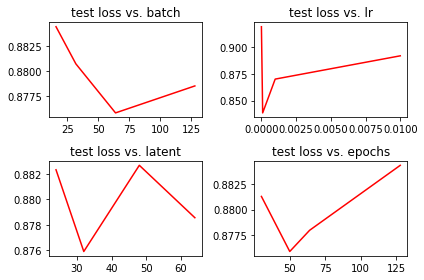

In [143]:
plot_comparison(df)

In [144]:
best_params = get_best_params(df)

In [145]:
x.drop(columns=["Unnamed: 0"], inplace=True)

In [146]:
best_params

batch        128.000000
lr             0.001000
latent        24.000000
epochs        30.000000
test_loss      0.775238
Name: 224, dtype: float64

In [147]:
y.columns

Index(['index', 'bulk_labels'], dtype='object')

In [149]:
def train(train_loader, best_params):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    
    criterion = nn.MSELoss()
    model = Autoencoder(input_shape=765, latent_space=int(best_params["latent"]))
    optimizer = torch.optim.Adam(model.parameters(), lr=best_params["lr"])

    for epoch in range(int(best_params["epochs"])):
        loss = 0
        for batch_feature, _ in train_loader:
            optimizer.zero_grad()
            batch_feature = batch_feature.view(-1, 765).to(device)
            outputs, encoding = model(batch_feature, return_encoding=True)
            current_loss = criterion(outputs, batch_feature)
            current_loss.backward()
            optimizer.step()
            loss+= current_loss.item()
        
        train_loss = loss/len(train_loader)
        print(f"Epoch: {epoch}, Train Loss: {train_loss}")
    
    return model

In [150]:
y = le.fit_transform(y["bulk_labels"])
X_tensor = torch.tensor(x.to_numpy(), dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

train_dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=int(best_params["batch"]), shuffle=True)

In [151]:
my_model = train(train_loader, best_params)

Epoch: 0, Train Loss: 1.0036831597487132
Epoch: 1, Train Loss: 1.0019518534342449
Epoch: 2, Train Loss: 0.9849027295907339
Epoch: 3, Train Loss: 0.9684053162733713
Epoch: 4, Train Loss: 0.9404179652531942
Epoch: 5, Train Loss: 0.9135062297185262
Epoch: 6, Train Loss: 0.8991595804691315
Epoch: 7, Train Loss: 0.8801102538903555
Epoch: 8, Train Loss: 0.8660794297854105
Epoch: 9, Train Loss: 0.8543198605378469
Epoch: 10, Train Loss: 0.8498741090297699
Epoch: 11, Train Loss: 0.8389114936192831
Epoch: 12, Train Loss: 0.8367263078689575
Epoch: 13, Train Loss: 0.8323053320248922
Epoch: 14, Train Loss: 0.8295948505401611
Epoch: 15, Train Loss: 0.819312592347463
Epoch: 16, Train Loss: 0.8176063795884451
Epoch: 17, Train Loss: 0.8232477506001791
Epoch: 18, Train Loss: 0.8112071653207144
Epoch: 19, Train Loss: 0.8076725800832113
Epoch: 20, Train Loss: 0.8028275966644287
Epoch: 21, Train Loss: 0.808588574330012
Epoch: 22, Train Loss: 0.7997381885846456
Epoch: 23, Train Loss: 0.7974185645580292
Epoc

In [95]:
def get_latent_representation(data_loader, model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_encodings = []
    labels = []
    
    with torch.no_grad():
        for batch_feature, label in data_loader:
            batch_feature = batch_feature.view(-1, 765).to(device)
            outputs, encoding = model(batch_feature, return_encoding=True)
            all_encodings.append(encoding.cpu())
            labels.append(label)
    return torch.cat(all_encodings, dim=0), torch.cat(labels, dim=0)

In [152]:
latent_representation, labels = get_latent_representation(train_loader, my_model)

Train your autoencoding using MSE loss.

Finally, identify the parameters which don't overfit, and use the same model architecture and train on all of the data together.

With a latent space size of 32, aim for 0.9 MSE loss on your test set, 0.95 with regularization. You will not be graded strictly on a loss cutoff.

In [106]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [165]:
def plot_2D(x, title):
    a1, a2 = [], []
    _ = [(a1.append(i[0]), a2.append(i[1])) for i in x]
    plt.scatter(a1, a2, c=y)
    plt.title(title.upper())

In [159]:
tsne = TSNE()
tsne_without_latent = tsne.fit_transform(x)

In [160]:
pca = PCA(n_components=2)
pca_without_latent = pca.fit_transform(x)

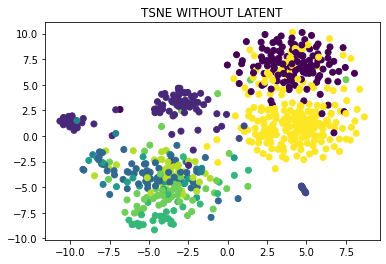

In [166]:
plot_2D(tsne_without_latent, "TSNE without latent")

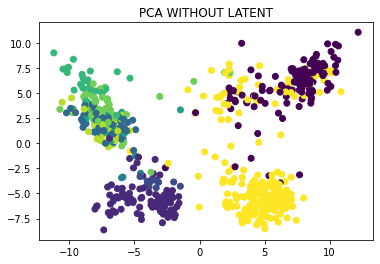

In [167]:
plot_2D(pca_without_latent, "PCA without latent")

Use PCA and t-SNE on the dataset.

Then use PCA on the latent space representation of the dataset.

Plot all of these.

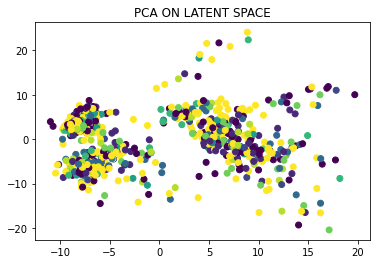

In [168]:
pca_latent = pca.fit_transform(latent_representation)
plot_2D(pca_latent, "PCA on latent space")

Compare the results of PCA, t-SNE, and your autoencoder as ways to visualize the data.